In [1]:
# PACING DETECTION: This program detects a user's behavior for stationary, walking, and pacing.

In [2]:
# -- IMPORTS START --
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import re
import warnings
import datetime
import pathlib
import glob
import numpy as np
import pandas as pd
import joblib
import pickle

from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
# -- IMPORTS END --

# enable graph zooming
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

# 'ipython' error workaround
#%matplotlib inline
# Mute FutureWarning for frame.append method
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# CONSTANTS
sampling_rate = 100 #Sensor Logger samples at 100Hz by default
window_sec = 10 #number of seconds to plot - upto 20 should be easy to visualize

In [4]:
# -- PREPROCESS DATA --
# preprocessor.py is python code that converts the files to a workable format.
# the timestamp column is converted from nanoseconds to seconds. 
# each separate file "Accelerometer" and "Magnetometer" have identical columns x, y, and z, so each are given a distinct renaming.

In [5]:
# calc_magnitude - removes effect of device orientation 
# This function takes a dataframe as a parameter. 
# It adds new columns calculated from x y & z accel and magnetometer values, with gravity removed as mean. 
# Its return value is the modified dataframe. 

In [6]:
def calc_magnitude(data):
    data['accel_mag'] = np.sqrt(data['accel_x']**2 + data['accel_y']**2 + data['accel_z']**2)
    data['accel_mag'] -= data['accel_mag'].mean()
    
    data['magno_mag'] = np.sqrt(data['magno_x']**2 + data['magno_y']**2 + data['magno_z']**2)
    data['magno_mag'] -= data['magno_mag'].mean()
    return data

In [7]:
# remove_noise - removes high frequency noise from the data
# This function takes a dataframe and a sampling_rate as parameters.
# This function applies lowpass butterworth filter using scipy's .butter and .filtfilt methods.
# The cutoff freq is 5 Hz and order of 2 to filter the data and cut off high freq noise.
# The filter is applied to the accel_mag column and stored in a new column called filtered_accel_mag.
# Its return value is the modified dataframe.

In [8]:
def remove_noise(data, sampling_rate):
    cutoff = 5
    order = 2
    nyq = sampling_rate * 0.5
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='lowpass')
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])
    data['filtered_magno_mag'] = filtfilt(b, a, data['magno_mag'])
    return data

In [9]:
# add_features - calculates statistical features from accel data windows. 
# This function takes a window as a parameter. 
# It calculates average, maximum, median, minimum, 25th percentile, 75th percentile, and standard deviation of the acceleration magnitude signal
# These features are stored in a new dataframe, which is returned. 

In [10]:
def add_features(window):
    features = {}
    features['a_avg'] = [window['filtered_accel_mag'].mean()]
    features['a_max'] = [window['filtered_accel_mag'].quantile(1)]
    features['a_med'] = [window['filtered_accel_mag'].quantile(0.5)]
    features['a_min'] = [window['filtered_accel_mag'].quantile(0)]
    features['a_q25'] = [window['filtered_accel_mag'].quantile(0.25)]
    features['a_q75'] = [window['filtered_accel_mag'].quantile(0.75)]
    features['a_std'] = [window['filtered_accel_mag'].std()]
    
    features['m_avg'] = [window['filtered_magno_mag'].mean()]
    features['m_max'] = [window['filtered_magno_mag'].quantile(1)]
    features['m_med'] = [window['filtered_magno_mag'].quantile(0.5)]
    features['m_min'] = [window['filtered_magno_mag'].quantile(0)]
    features['m_q25'] = [window['filtered_magno_mag'].quantile(0.25)]
    features['m_q75'] = [window['filtered_magno_mag'].quantile(0.75)]
    features['m_std'] = [window['filtered_magno_mag'].std()]
    
    return pd.DataFrame(features)

In [11]:
# extract_features - extracts features from accelerometer data applying a sliding window approach.
# This function takes parameters including: data (filtered accel data), window_sec (window len in seconds), sample_rate (sampling freq), and activity (behavior label)
# The windowing method uses pandas.DataFrame.resample. 
# For each window in the resampled data, the add_features function is called. 
# The computed features are appended to a new df and returned. 

In [12]:
def extract_features(data, window_sec, sample_rate, activity):
    print("extract_features")
    dfs = []
    # reformat timestamp
    data['time'] = pd.to_datetime(data['time'])
    windows = data.set_index('time').resample('{}S'.format(window_sec))
    # Iterate over each window in data using sliding window approach
    num_windows = len(windows)
    count = 0
    for time, window in windows:
        count += 1
        if count % 1000 == 0:
            print(f"window {count} of {num_windows}")
        # add_features() returns a df
        features = add_features(window)
        features['activity'] = activity
        dfs.append(features)

    return pd.concat(dfs, ignore_index = True)

In [13]:
# -- CLASSIFIER FUNCTIONS --

In [14]:
# viz_tree - creates a visualization using sklearn.plot_tree 

In [15]:
def viz_tree(dt_model,feature_names,cnames):
    fig, ax = plt.subplots(figsize=(12,7.5))
    tree.plot_tree(dt_model,  
                   feature_names=feature_names,
                   fontsize=12,
                   class_names=cnames,
                   filled=True,
                   ax=ax)

    plt.title('Decision Tree')
    plt.savefig('dt.png')

In [16]:
# train_tree - trains a Decision Tree Classifier on the provided features and labels
# This function takes frames as a parameter: a DataFrame containing the computed features and labels
# The function splits the dataframe using sklearn.model_selection into features matrix X and labels vector y
# It creates training and test sets using test size of 0.3 and a random state of 42.
# It trains the Decision Tree Classifier using sklearn.tree with entropy criterion and maximum depth of 3
# The return values are: dt_model (the tree model), dt_cm (the confusion matrix), and acc (accuracy score)

In [17]:
def train_tree(frames):
    # X = feature columns 
    #X = frames[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std']]
    frames = frames.dropna()
    print(frames)
    X = frames[['a_avg',
                'a_max',
                'a_med',
                'a_min',
                'a_q25',
                'a_q75',
                'a_std',
                'm_avg',
                'm_max',
                'm_med',
                'm_min',
                'm_q25',
                'm_q75', 
                'm_std']]
    # y = target column
    y = frames['activity']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    # Create model with 'entropy' criterion and max dept 3 on training set
    dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=3).fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)

    # predict test set as 'dt_model' and 'dt_cm' and calculate accuracy as 'acc'
    acc = dt_model.score(X_test, y_test)
    dt_cm = confusion_matrix(y_test, dt_pred, labels=dt_model.classes_)
    
    print(classification_report(y_test, dt_pred))
    print(dt_cm)
    print("Accuracy on test set:", acc)
    print("Accuracy, Rounded to Nearest Hundredth:", acc.round(2))

    return dt_model,dt_cm,acc

In [18]:
# create_classifier - creates a Decision Tree Classifier from all provided data files.
# The parameters include: all_files (a list of filenames) 
# For each file in all_files, data is loaded into a dataframe using pd.read_csv.
# calc_magnitude, remove_noise, extract_features are called.
# The features are appended to a new df, used to train the decision tree.
# the dt_model, dt_cm, and acc are created from this and returned.
# The model is saved using pickle.

In [19]:
def create_classifier(all_files):
    dfs = []
    if os.path.isfile("dt_model2.pkl"):
        with open("dt_model2.pkl", "rb") as file:
            model = pickle.load(file)
            return (model, None, None)
    for file in all_files:
        print(file)
        sampling_rate = 100
        activity = os.path.basename(os.path.dirname(file))
        #data = pd.read_csv(file,parse_dates=['timestamp'],index_col='timestamp',)
        data = pd.read_csv(file)
        data = calc_magnitude(data)
        data = remove_noise(data,sampling_rate)        
        feature_frames = extract_features(data,10,sampling_rate,activity)
        dfs.append(feature_frames)
    
    features_data = pd.concat(dfs, ignore_index = True)
    dt_model, dt_cm, acc = train_tree(features_data)
    
    # save trained model using pickle.dump
    pickle.dump(dt_model, open("dt_model2.pkl", "wb"))
    return dt_model, dt_cm, acc

In [20]:
# classify_live_window - preprocesses data in a similar manner as before, including:
# calc_magnitude, remove_noise, and extrat_features from data window. 
# Then the features are fed to the trained decision tree model to predict activity.

In [21]:
def classify_live_window(df):
    
    # Filter accelerometer data 
    df = df[df['accel_x'].notna() & df['accel_y'].notna() & df['accel_z'].notna() & df['magno_x'].notna() & df['magno_y'].notna() & df['magno_z'].notna()]
    # df_valid = df_accel[['accel_x', 'accel_y', 'accel_z']].rename(columns={
    #   'accel_x': 'x',
    #   'accel_y': 'y',
    #   'accel_z': 'z'  
    # })
    
    # Filter mag data
    #df_mag = df[df['magno_x'].notna() & df['magno_y'].notna() & df['magno_z'].notna()]
    # df_valid = df_mag[['magno_x', 'magno_y', 'magno_z']].rename(columns={
    #   'magno_x': 'mx',
    #   'magno_y': 'my',
    #   'magno_z': 'mz'  
    # })   

    # Calculate accel_mag
    df = calc_magnitude(df) 

    # Add features
    df = add_features(df) 
    X = df[['a_avg',
                'a_max',
                'a_med',
                'a_min',
                'a_q25',
                'a_q75',
                'a_std', 
                'm_avg',
                'm_max',
                'm_med',
                'm_min',
                'm_q25',
                'm_q75', 
                'm_std']] 

    # Load model
    with open('dt_model.pkl', 'rb') as f:
        model = pickle.load(f)
        
    # Make prediction
    y_pred = model.predict(df)

    return(y_pred)

In [22]:
# test_live_classifier - Uses synthetic data to test functionality
# This function creates a sample DataFrame with a single row repeated 1000 times to simulate a live stream of data.
# classify_live_window() is called with this df as its argument to preprocess the data. 
# Then the features are fed to the trained decision tree model to predict activity (y_pred)
# y_pred is printed to the console.

In [23]:
def test_live_classifier(): # Testing the live model
    # Generate sample DataFrame
    data = {'accel_x': [0.011531], 
            'accel_y': [0.002931],
            'accel_z': [0.019604],
            'magno_x': [0.011531], 
            'magno_y': [0.002931],
            'magno_z': [0.019604], 
            'time': ['2023-08-01 18:40:43.344408']}

    df = pd.DataFrame(data)

    # Repeat rows to get 1000 rows
    df = pd.concat([df]*1000, ignore_index=True) 

    # Call function
    y_pred = classify_live_window(df)

    print(y_pred)

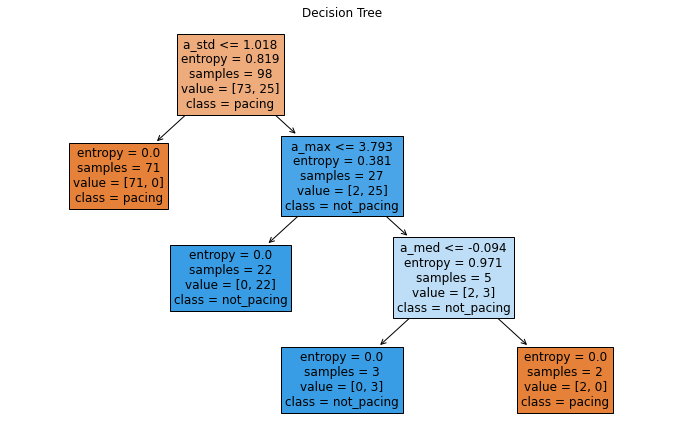

In [24]:
# -- MAIN --
# Go through the individual filenames by changing the below filenames and path and record accuracy in above table  
#filenames = glob.glob("data/assignment_data/**/*")
filenames = glob.glob("data/steps_data/**/AccelMagno.csv")
# create_classifier saves to pickle
dt_model,dt_cm,acc = create_classifier(filenames)

fnames = ['a_avg',
          'a_max',
          'a_med',
          'a_min',
          'a_q25',
          'a_q75',
          'a_std',
          'm_avg',
          'm_max',
          'm_med',
          'm_min',
          'm_q25',
          'm_q75',
          'm_std']

viz_tree(dt_model, fnames, ['pacing', 'not_pacing'])

if dt_cm and acc:
    print(acc)
    print(acc.round(2))
    